In [1038]:
#https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
#https://archive.ics.uci.edu/dataset/109/wine

In [1039]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [1040]:
!pip install ucimlrepo

In [1041]:
from ucimlrepo import fetch_ucirepo

In [1042]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1043]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1044]:
# import breast cancer & wine datasets
breast_cancer = fetch_ucirepo(id=17)
wine = fetch_ucirepo(id=109)

print(breast_cancer.variables)
print(wine.variables)

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

In [1045]:
random_shuffle_state = 2024

In [1046]:
scaler = StandardScaler()

In [1047]:
def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [1048]:
wine.data.targets['class'] = wine.data.targets['class'] - 1
wine_X_train, wine_y_train, wine_X_valid, wine_y_valid, wine_X_test, wine_y_test = train_valid_test_split(wine.data.features, wine.data.targets)

<ipython-input-1048-b48e8fa4a2fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.data.targets['class'] = wine.data.targets['class'] - 1


In [1049]:
breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'
breast_X_train, breast_y_train, breast_X_valid, breast_y_valid, breast_X_test, breast_y_test = train_valid_test_split(breast_cancer.data.features, breast_cancer.data.targets)

<ipython-input-1049-9c176ede9c04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'


In [1050]:
wine_X_train = scaler.fit_transform(wine_X_train)
wine_X_valid = scaler.fit_transform(wine_X_valid)
wine_X_test = scaler.fit_transform(wine_X_test)

wine_X_train = torch.tensor(wine_X_train, dtype=torch.float32)
wine_X_valid = torch.tensor(wine_X_valid, dtype=torch.float32)
wine_X_test = torch.tensor(wine_X_test, dtype=torch.float32)

wine_y_train = torch.tensor(wine_y_train.values, dtype=torch.long).flatten()
wine_y_valid = torch.tensor(wine_y_valid.values, dtype=torch.long).flatten()
wine_y_test = torch.tensor(wine_y_test.values, dtype=torch.long).flatten()

In [1051]:
breast_X_train = scaler.fit_transform(breast_X_train)
breast_X_valid = scaler.fit_transform(breast_X_valid)
breast_X_test = scaler.fit_transform(breast_X_test)

breast_X_train = torch.tensor(breast_X_train, dtype=torch.float32)
breast_X_valid = torch.tensor(breast_X_valid, dtype=torch.float32)
breast_X_test = torch.tensor(breast_X_test, dtype=torch.float32)

breast_y_train = torch.tensor(breast_y_train.values, dtype=torch.long).flatten()
breast_y_valid = torch.tensor(breast_y_valid.values, dtype=torch.long).flatten()
breast_y_test = torch.tensor(breast_y_test.values, dtype=torch.long).flatten()

In [1052]:
class WineNN(nn.Module):
  def __init__(self, num_features, hidden_size, output_size):
    super(WineNN, self).__init__()
    self.layer1 = nn.Linear(num_features, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.out(x)
    return self.softmax(x)

In [1053]:
wine_num_features = wine_X_train.shape[1]

In [1054]:
model = WineNN(wine_num_features, 64, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [1055]:
class BreastCancerNN(nn.Module):
  def __init__(self, num_features, hidden_size, output_size):
    super(BreastCancerNN, self).__init__()
    self.layer1 = nn.Linear(num_features, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.out(x)
    return self.softmax(x)

In [1056]:
breast_cancer_num_features = breast_X_train.shape[1]

In [1057]:
def train(X_train, y_train, X_valid, y_valid, model, criterion, optimizer, dataset_name):
  loss_values = []
  val_loss_values = []
  len_x_train = len(X_train)
  len_y_valid = len(y_valid)
  for epoch in range(10):
      running_loss = 0.0
      for i, data in enumerate(X_train, 0):
          inputs = data
          labels = y_train[i]
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % len_x_train == len_x_train - 1:
              print(f"[{epoch + 1}, {i + 1}] train loss: {running_loss / len_x_train:.3f}")
              loss_values.append(running_loss / len_x_train)
              running_loss = 0.0
      model.eval()
      val_loss = 0.0
      correct = 0
      with torch.no_grad():
          for i, data in enumerate(X_valid, 0):
              inputs = data
              labels = y_valid[i]
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs, 0)
              correct += (predicted == labels).sum().item()
              if i % len_y_valid == len_y_valid - 1:
                print(f"[{epoch + 1}, {i + 1}] validation loss: {val_loss / len_y_valid:.3f}")
                val_loss_values.append(val_loss / len_y_valid)
                val_loss = 0.0
  plt.plot(loss_values)
  plt.title(f"{dataset_name} dataset - training loss")
  plt.show()
  plt.plot(val_loss_values)
  plt.title(f"{dataset_name} dataset - validation loss")
  plt.show()

In [1058]:
def test(X_test, y_test, model, criterion, optimizer, dataset_name):
  correct = 0
  predictions = []
  with torch.no_grad():
      for i, data in enumerate(X_test, 0):
          inputs = data
          labels = y_test[i]
          outputs = model(inputs)
          predicted = outputs.cpu().numpy().argmax(axis=0)
          predictions.append(predicted)
          correct += (predicted == labels).sum().item()

  print(f"Accuracy on the test set: {100 * correct / len(y_test):.2f}%")
  return predictions

In [1059]:
def present_metrics(predictions, y_test, targets):
  # Accuracy
  y_true = y_test.cpu().numpy()
  y_pred = np.array(predictions)
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)

  # Precision
  precision = precision_score(y_true, y_pred, average='weighted')
  print("Precision:", precision)

  # Recall
  recall = recall_score(y_true, y_pred, average='weighted')
  print("Recall:", recall)

  # F1 Score
  f1 = f1_score(y_true, y_pred, average='weighted')
  print("F1 Score:", f1)

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                            display_labels=np.unique(targets))
  disp.plot()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1, 124] train loss: 0.860
[1, 17] validation loss: 0.596
[2, 124] train loss: 0.596
[2, 17] validation loss: 0.580
[3, 124] train loss: 0.574
[3, 17] validation loss: 0.566
[4, 124] train loss: 0.564
[4, 17] validation loss: 0.565
[5, 124] train loss: 0.561
[5, 17] validation loss: 0.557
[6, 124] train loss: 0.557
[6, 17] validation loss: 0.572
[7, 124] train loss: 0.560
[7, 17] validation loss: 0.554
[8, 124] train loss: 0.553
[8, 17] validation loss: 0.555
[9, 124] train loss: 0.553
[9, 17] validation loss: 0.554
[10, 124] train loss: 0.553
[10, 17] validation loss: 0.554


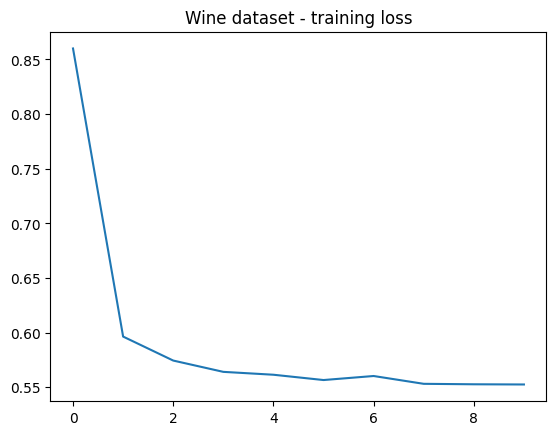

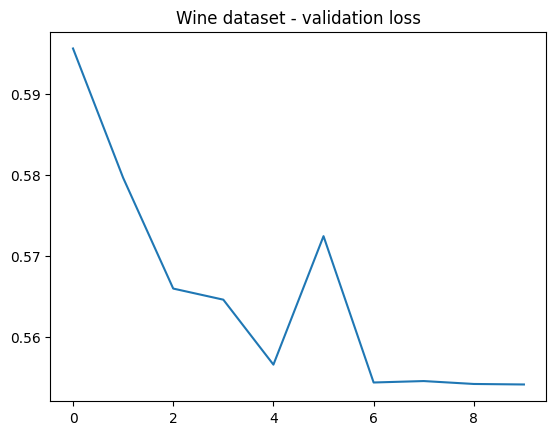

Accuracy on the test set: 91.89%
Accuracy: 0.918918918918919
Precision: 0.9376299376299376
Recall: 0.918918918918919
F1 Score: 0.9205213118256597


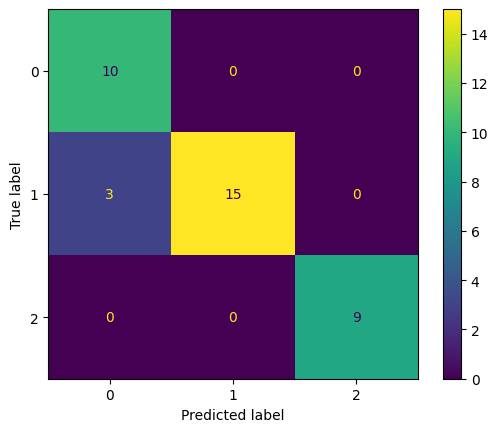

In [1060]:
train(wine_X_train, wine_y_train, wine_X_valid, wine_y_valid, model, criterion, optimizer, 'Wine')
wine_predictions = test(wine_X_test, wine_y_test, model, criterion, optimizer, 'Wine')
present_metrics(wine_predictions, wine_y_test, wine.data.targets)

In [1061]:
model = BreastCancerNN(breast_cancer_num_features, 32, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1, 398] train loss: 0.412
[1, 56] validation loss: 0.404
[2, 398] train loss: 0.340
[2, 56] validation loss: 0.406
[3, 398] train loss: 0.333
[3, 56] validation loss: 0.409
[4, 398] train loss: 0.328
[4, 56] validation loss: 0.409
[5, 398] train loss: 0.325
[5, 56] validation loss: 0.405
[6, 398] train loss: 0.324
[6, 56] validation loss: 0.401
[7, 398] train loss: 0.324
[7, 56] validation loss: 0.401
[8, 398] train loss: 0.323
[8, 56] validation loss: 0.412
[9, 398] train loss: 0.323
[9, 56] validation loss: 0.420
[10, 398] train loss: 0.323
[10, 56] validation loss: 0.410


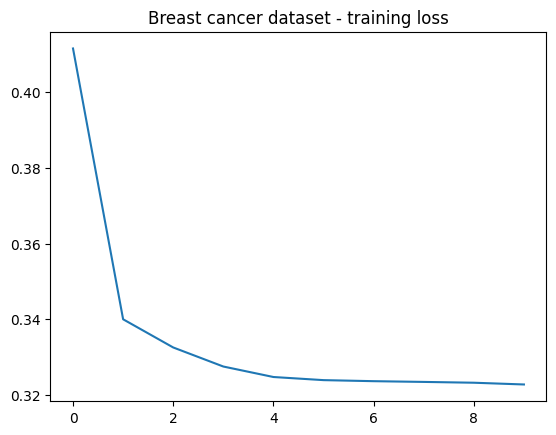

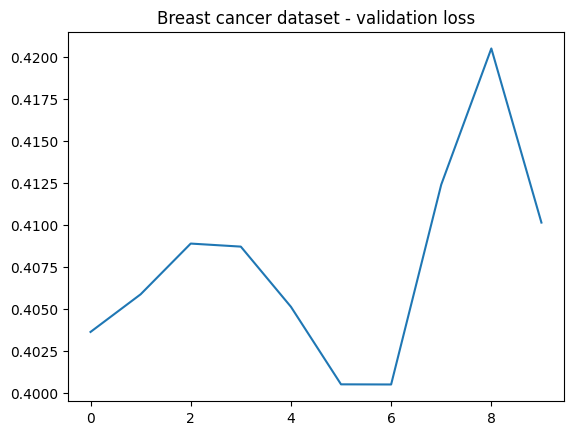

Accuracy on the test set: 97.39%
Accuracy: 0.9739130434782609
Precision: 0.9749851101846336
Recall: 0.9739130434782609
F1 Score: 0.9737369077698913


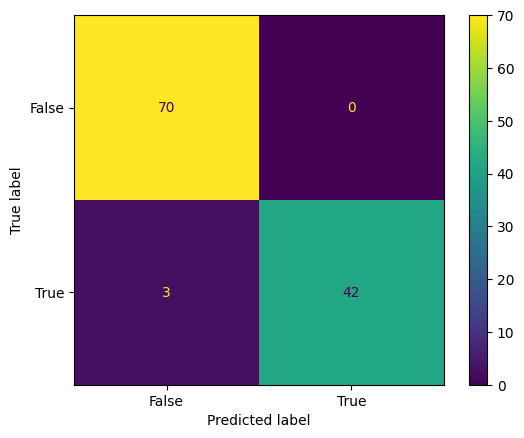

In [1062]:
train(breast_X_train, breast_y_train, breast_X_valid, breast_y_valid, model, criterion, optimizer, 'Breast cancer')
breast_predictions = test(breast_X_test, breast_y_test, model, criterion, optimizer, 'Breast cancer')
present_metrics(breast_predictions, breast_y_test, breast_cancer.data.targets)